In [1]:
from multiprocessing import Pool
import os
os.environ['OMP_NUM_THREADS'] = "1"

import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from astropy.io import fits
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from dustmaps.bayestar import BayestarQuery
from dustmaps.vergely2022 import Vergely2022Query
from dustmaps.edenhofer2023 import Edenhofer2023Query

import pickle 
import sys
import os
import tqdm

import emcee
import corner

import h5py

In [2]:
import globalvars
dust_data = globalvars.DustData()

In [3]:
from sightline import Sightline
from specfns import get_wavs, resample_interp, dopplershift, lambda0, sigma0
from filehandling import get_ca_res, get_madgics_res
from spacefns_v2 import select_stars, find_nearest, find_radius, differentialAmplitude
from MCMCfns import logprob_2
import time

# import globalvars
# dust_data = globalvars.DustData()
# with h5py.File(map_fname, 'r') as f:
#     edenhofer = np.array(f['data'])
#     dust_data.intake_map(edenhofer)

In [4]:
map_fname = '/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/edenhofer_out.h5'

with h5py.File(map_fname, 'r') as f:
    edenhofer = np.array(f['data'])
    dust_data.intake_map(edenhofer)

In [5]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230420_CAResiduals/'
CAMADGICSresdir = '/uufs/astro.utah.edu/common/home/u1371365/Data/230829_MADGICSResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

CA_meta_full = CA_meta.copy()

with open('/uufs/astro.utah.edu/common/home/u1371365/DIB_KT_CACloud/goodbad.pickle', mode = 'rb') as f:
    goodbad = pickle.load(f)
## used up until 1003a at least
# CA_meta = CA_meta[goodbad]
# print(len(CA_meta))

# CA_filter = (CA_meta['SNR'] > 70) & (chi2_array < 1/70)
# CA_meta = CA_meta[CA_filter]

### starting 1003b
strict_filter = (CA_meta['SNR'] > 150) & goodbad
CA_meta = CA_meta[strict_filter]
print(len(CA_meta))

335


In [27]:
wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
wavs_window = wavs[window]

In [7]:
ds = 2.5 # x downsampled
rad = 0.23
sample_dim_l = np.linspace(159, 167, int(8 / (ds * rad)))
sample_dim_b = np.linspace(-12.5 , -4.5, int(8 / (ds * rad)))
sample_grid_l, sample_grid_b = np.meshgrid(sample_dim_l, sample_dim_b)
grid_map_inds = np.array([find_nearest(sample_grid_l.flatten()[i], sample_grid_b.flatten()[i]) for i in range(len(sample_grid_l.flatten()))]).T
grid_map = np.nansum(np.copy(edenhofer[grid_map_inds[1], grid_map_inds[0], :]).reshape(*sample_grid_l.shape, -1), axis = 2)
grid_Nstar = np.array([np.nansum((np.abs((sample_grid_l.flatten()[i] - CA_meta['GLON'])) <= rad) & 
            (np.abs((sample_grid_b.flatten()[i] - CA_meta['GLAT'])) <= rad)) for i in range(len(sample_grid_l.flatten()))]).reshape(*sample_grid_l.shape)

filament_l = (159, 169)
filament_b = (-10, -6)

N_min = 5
radius_min = np.zeros(sample_grid_l.shape)
mgrid = np.mgrid[0:len(sample_dim_l), 0:len(sample_dim_b)]
for i in mgrid[0].flatten():
    for j in mgrid[1].flatten():
        radius_min[i, j] = find_radius(sample_grid_l[i, j], sample_grid_b[i, j], N_min, CA_meta)
        radius_min[i, j] = np.max([radius_min[i, j], 0.23])

radius_max = 0.4
print(np.nansum(radius_min < radius_max))


crit_filament = ((sample_grid_l > filament_l[0]) & (sample_grid_l < filament_l[1]) & 
                 (sample_grid_b > filament_b[0]) & (sample_grid_b < filament_b[1]) &
                 (grid_map > 2.2) & (radius_min < 0.5)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

crit_background =  (((sample_grid_l <= filament_l[0]) | (sample_grid_l >= filament_l[1]) |
                 (sample_grid_b <= filament_b[0]) | (sample_grid_b >= filament_b[1])) &
                 (grid_map <= 1.5) & (radius_min < radius_max)) #(grid_Nstar > 5) & (grid_Nstar <= 10))

# crit_coverage = (np.sum() => 1 & )

N_filament = np.sum(crit_filament)
N_background = np.sum(crit_background)
print(np.sum(crit_filament))
print(np.sum(crit_background))

17
15
3


In [8]:
l_fil, b_fil, AV_fil = (sample_grid_l[crit_filament].flatten(), sample_grid_b[crit_filament].flatten(),
                        grid_map[crit_filament].flatten())
l_off, b_off, AV_off = (sample_grid_l[crit_background].flatten(), sample_grid_b[crit_background].flatten(),
                        grid_map[crit_background].flatten())

l_sample, b_sample, AV_sample = (np.concatenate([l_fil, l_off]), np.concatenate([b_fil, b_off]),
                                  np.concatenate([AV_fil, AV_off]))

In [9]:
radius_min_fil = radius_min[crit_filament].flatten()
radius_min_off = radius_min[crit_background].flatten()
radius_sample = np.concatenate([radius_min_fil, radius_min_off])

selected_inds = []
for i in range(len(l_sample)):
    l_center, b_center = l_sample[i], b_sample[i]
    rad_i = radius_sample[i]
    selection = select_stars(CA_meta, l_center, b_center, radius = rad_i)
    print(len(selection))
    selected_inds.append(selection)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
5
5


In [10]:
from sightline import Sightline

In [11]:
sightlines = []
for i in range(len(selected_inds)):
    indx = selected_inds[i]
    sightlines.append(Sightline(CA_meta[indx], MADGICS = False, dustdata = dust_data))
    sightlines[i].intake_coords(l_sample, b_sample, AV = AV_sample)

In [12]:
from MCMCfns import logprob_2

In [13]:
def MCMC_scary(sl, steps = 1000, nwalkers = 100, pool = None):
    ndim = len(sl.voxel_dAVdd) 
    nstar = len(sl.stars)
    ndim_amp = int(ndim + ndim * nstar)
    

    # dAVdd_prior = sl.dAVdd[:]
    # dAVdd_prior[dAVdd_prior == 0] = np.nan 
    # dAVdd_prior_med = np.nanmedian(dAVdd_prior, axis = 1)
    # dAVdd_prior_std = np.nanstd(dAVdd_prior, axis = 1, ddof = 1)
    # gaussparams = (dAVdd_prior_med, dAVdd_prior_std)
    # print(gaussparams)

    # with Pool(15) as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim_amp , logprob_2, 
                                    kwargs={'sl': sl,  'prior_mult':  1, 'v_max': 20, 'sigma': None}, pool = pool)
    # init = 12.5 *(np.random.random((nwalkers, ndim_amp)) - 0.5)
    init = 10 *  (np.random.random((nwalkers, ndim_amp)) - 0.5)

    init[:, ndim:] = np.abs(sl.dAVdd.ravel()[np.newaxis, :] + 0.1*(np.random.random(init[:, ndim:].shape)-0.5))
    print('NDIM:', ndim, 'NSTAR:', nstar, 'INITSHAPE:', init.shape)
    
    sampler.run_mcmc(init,  steps, progress = True);
    
    return sampler, ndim, ndim_amp

In [14]:
stp = 1500
# sampler, ndim, ndim_amp = MCMC_scary(a, steps = stp, nwalkers = 500)
# sampler1, ndim1, ndim_amp1 = MCMC(a1, steps = stp)
# sampler2, ndim2, ndim_amp2 = MCMC(a2, steps = stp)
# sampler3, ndim3, ndim_amp3 = MCMC(a3, steps = stp)

run_label = 'AAAA'
save_individual = False

first_run = False 



if first_run:
    if not os.path.exists(os.getcwd() + '/RUNS/' + run_label):
        os.makedirs(os.getcwd() +'/RUNS/' + run_label)
    with Pool(20) as pool:
        for i in range(len(sightlines)):
            try:
                sl_i = sightlines[i]
                smplr, ndm, ndm_amp = MCMC_scary(sl_i, steps = stp, nwalkers = 500, pool = pool)
                # smplr_array.append(smplr)
                # mid = time.time()
                # print('Time mid - start', mid - start) # beat 7:22
                # smplr_, ndim_ = MCMC_vonly(sl_i, smplr, steps = 1200, nwalkers = 100, pool = None)
                # end = time.time()
                # print('Time end - start:',(end - start)/60)
                sl_i.intake(smplr)
                state = 'success'
            except Exception as e:
                print('Something went wrong')
                sl_i = None 
                state = 'fail'
                with open('RUNS/' + run_label + '/FAILS.txt', mode = 'a') as fails:
                    fails.write(str(e))
                
            with open('RUNS/' + run_label + '/LOG.txt', mode = 'a') as log:
                logstring = time.asctime() + ' | ' + str(i) + ' | ' + state + '\n'
                log.write(logstring)
            
            if save_individual == True:
                with open('RUNS/' + run_label + '/sl_{}.pickle'.format(i), mode = 'wb') as f:
                    pickle.dump(sl_i, f)

# sampler, ndim, ndim_amp = smplr, ndm, ndm_amp

In [15]:
name = run_label

# first_run = True

if first_run:
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name),'wb')
    pickle.dump(sightlines, f )
    f.close()
else:
    f = open('RUNS/' + run_label + '/sightlines_{}.pickle'.format(name), 'rb')

    sightlines = pickle.load(f)
    f.close()

(100000, 5)


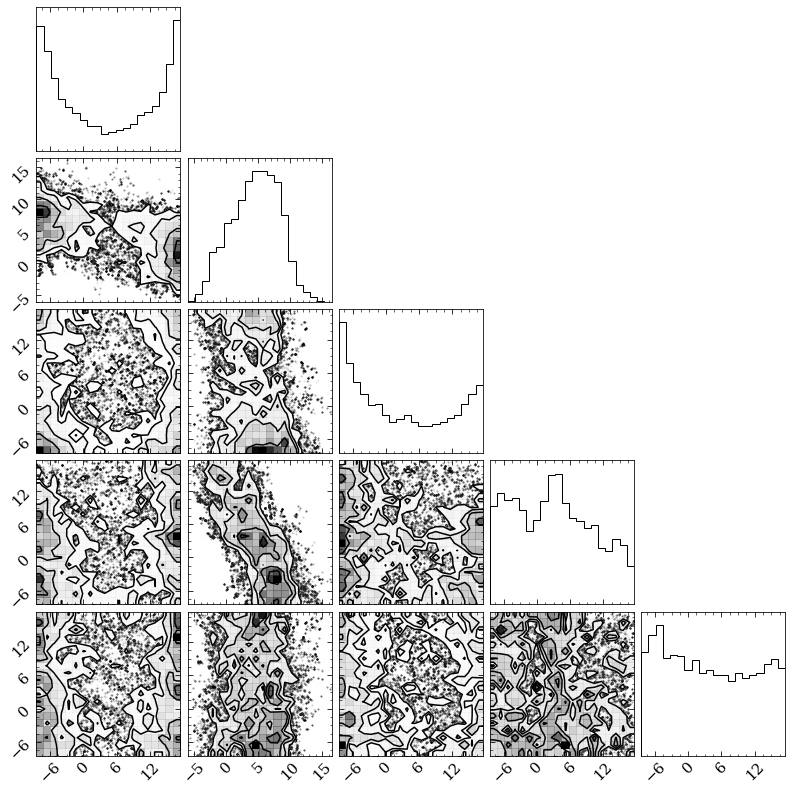

(100000, 5)


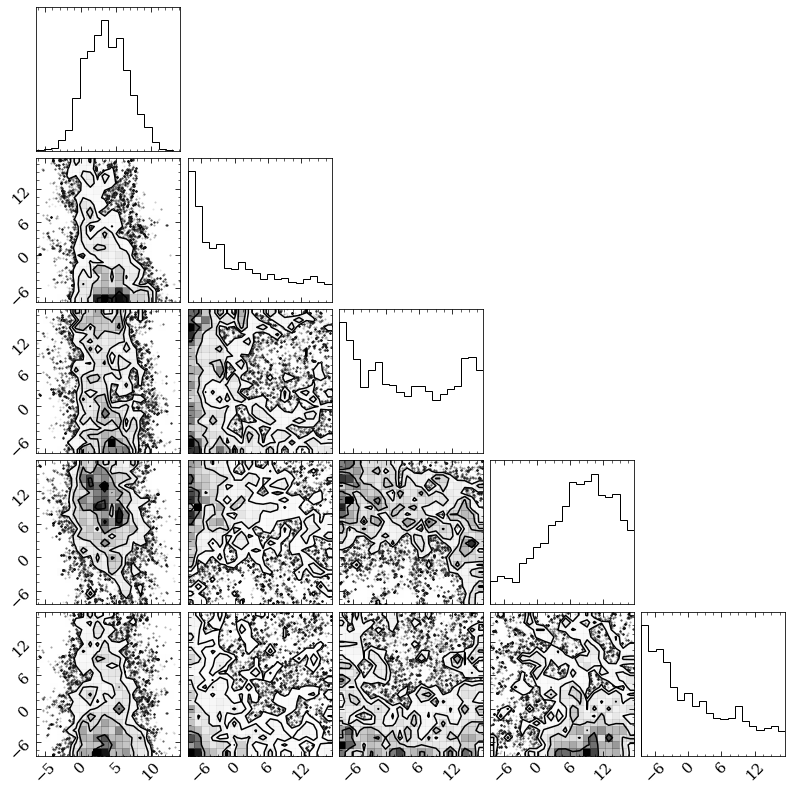

(100000, 4)


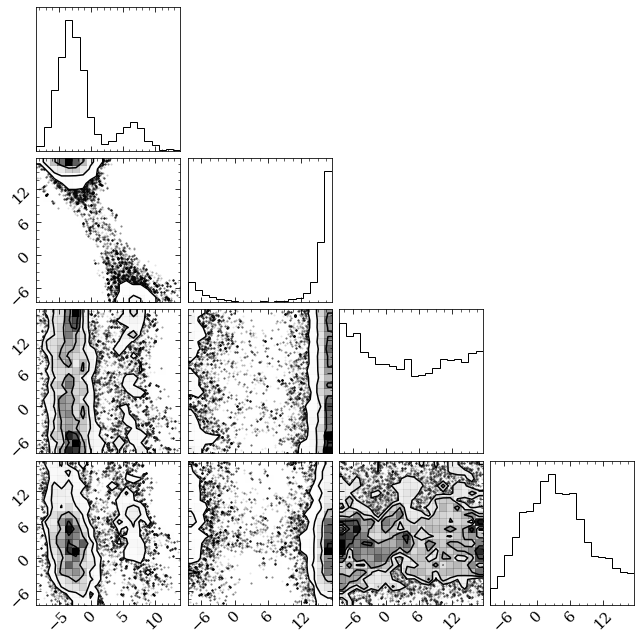

(100000, 5)


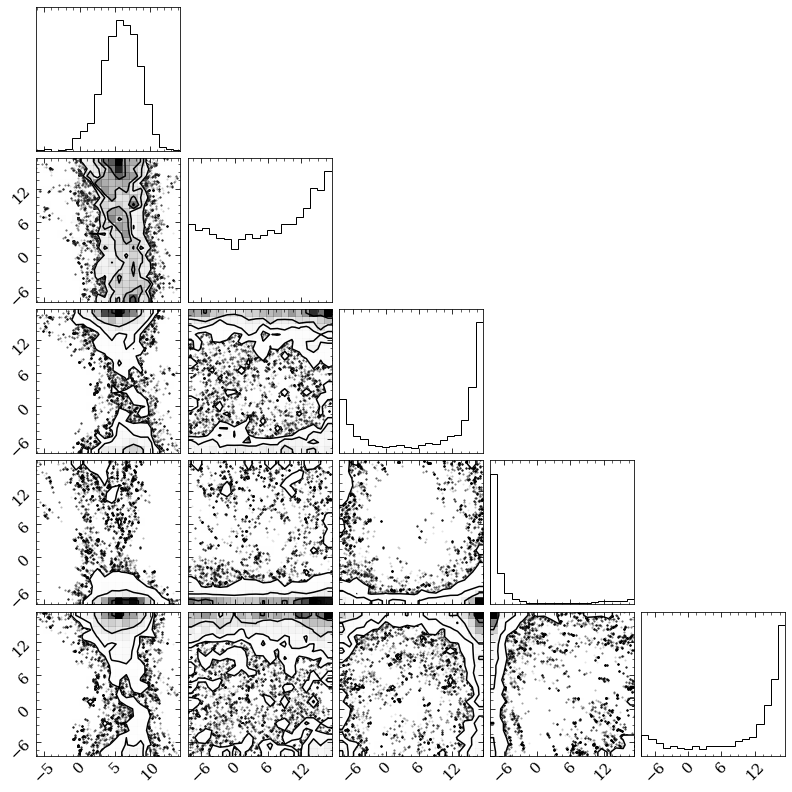

(100000, 5)


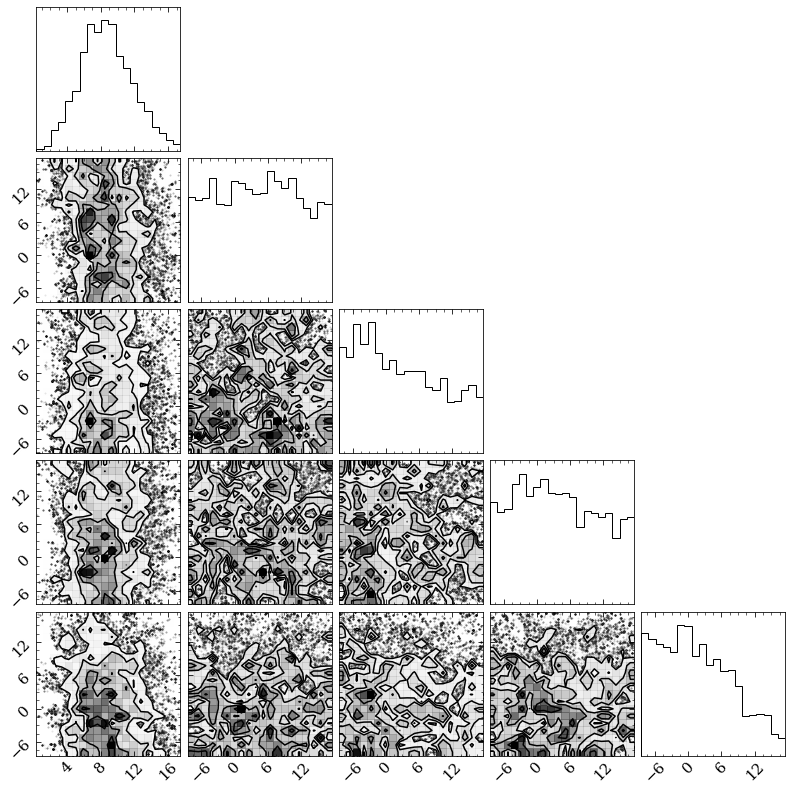

In [16]:
def make_corner(sampler, labels, minval = 50):
    dim = sampler.chain.shape[-1]
    samples = sampler.chain[:, minval:, :].reshape((-1, dim))
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

def make_corner_vonly(sampler, ndim, labels, minval = -100):
    samples = sampler.chain[:, minval:, :ndim].reshape((-1, ndim))
    print(samples.shape)
    # print(samples)
    fig = corner.corner(samples, figsize = (20, 20), labels = labels)
    # for ax in fig.axes:
        # ax.set_xlim(-15, 15)
        # ax.set_ylim(-15, 15) 
    plt.show()

if True:
    for i in range(0, len(sightlines), 4):
        sl_i = sightlines[i]
        ndim = len(sl_i.bins) - 1 
        make_corner_vonly(sl_i.sampler, ndim, labels = None, minval =-200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 0
(5, 95) (5, 5, 95) (5, 5)


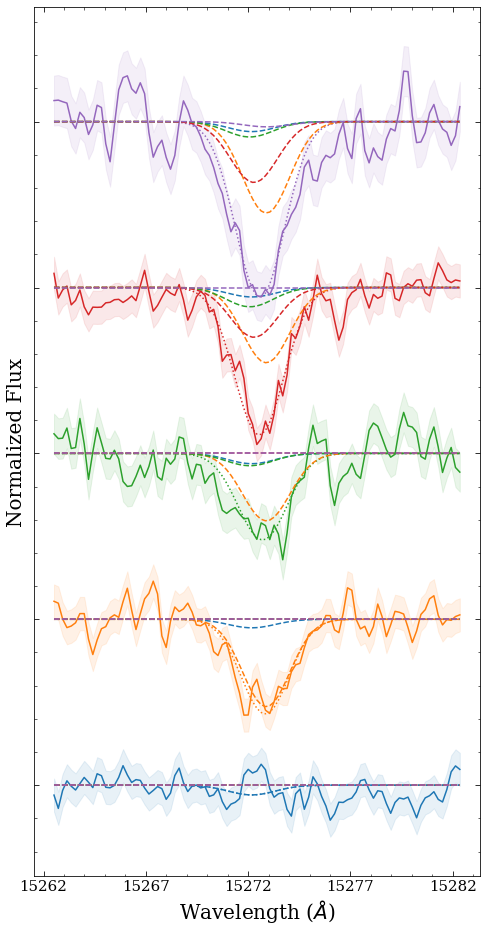

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 1
(5, 95) (5, 5, 95) (5, 5)


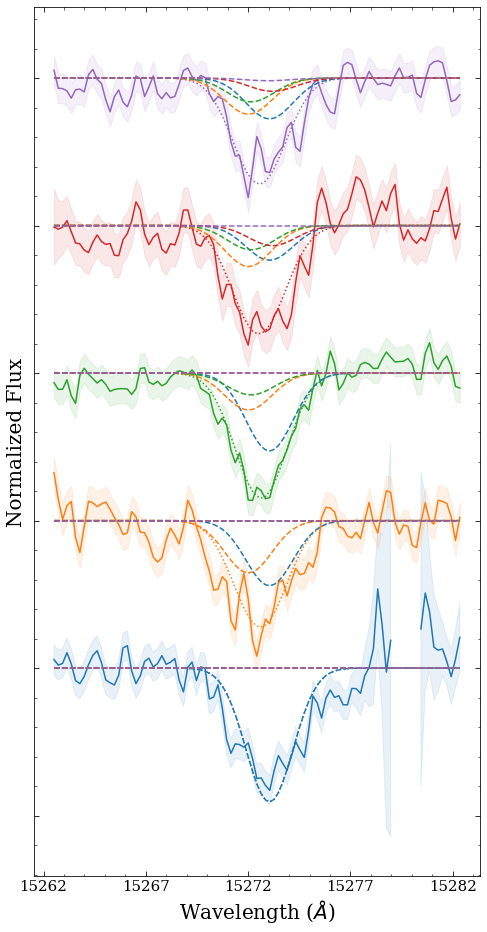

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 2
(5, 95) (5, 5, 95) (5, 5)


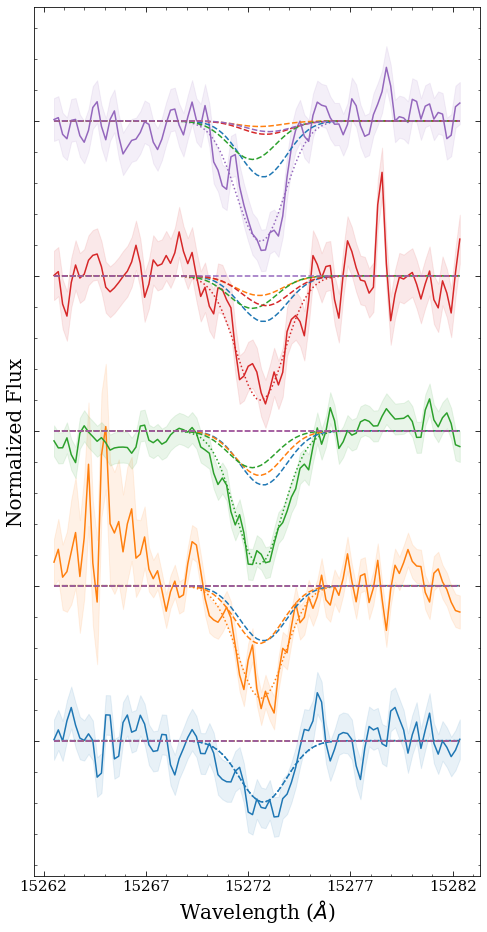

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 3
(5, 95) (5, 5, 95) (5, 5)


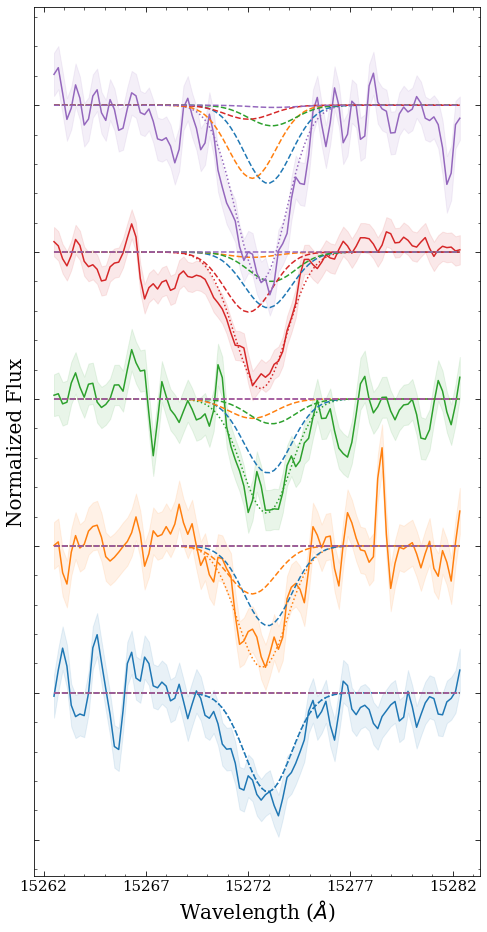

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 4
(5, 95) (5, 5, 95) (5, 5)


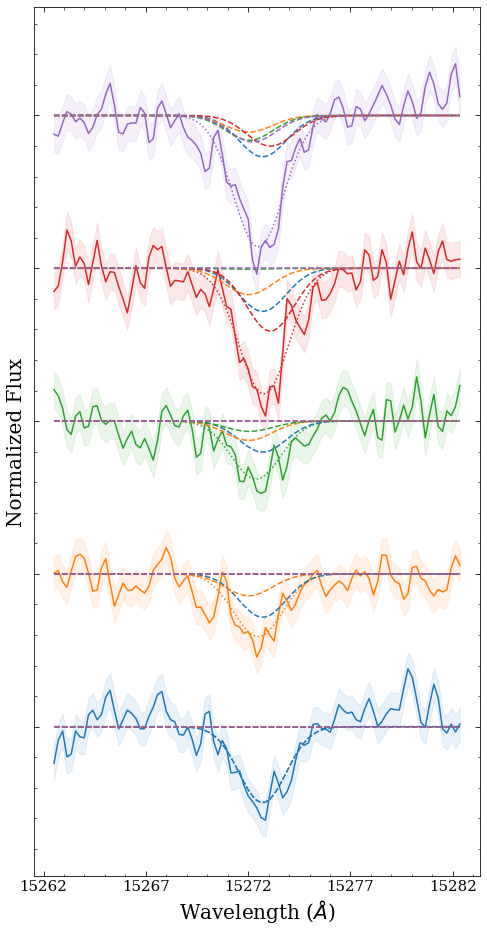

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 5
(5, 95) (5, 5, 95) (5, 5)


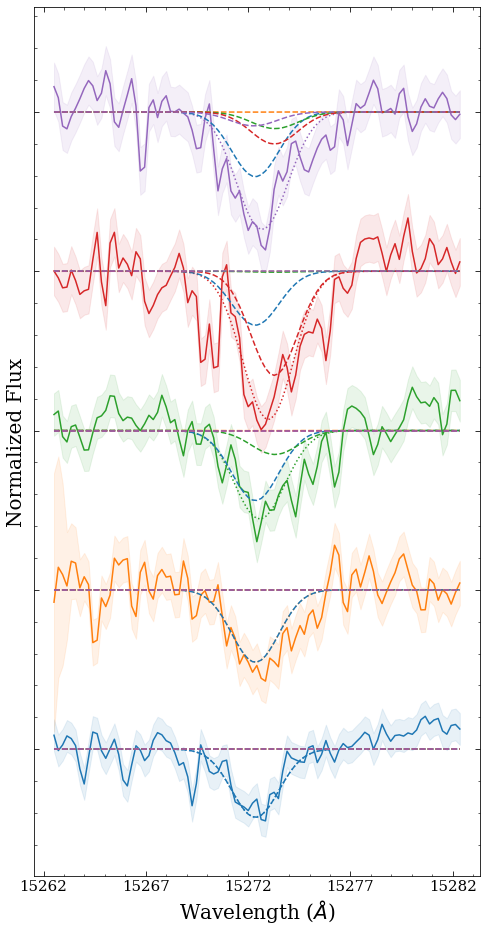

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 6
(5, 95) (5, 5, 95) (5, 5)


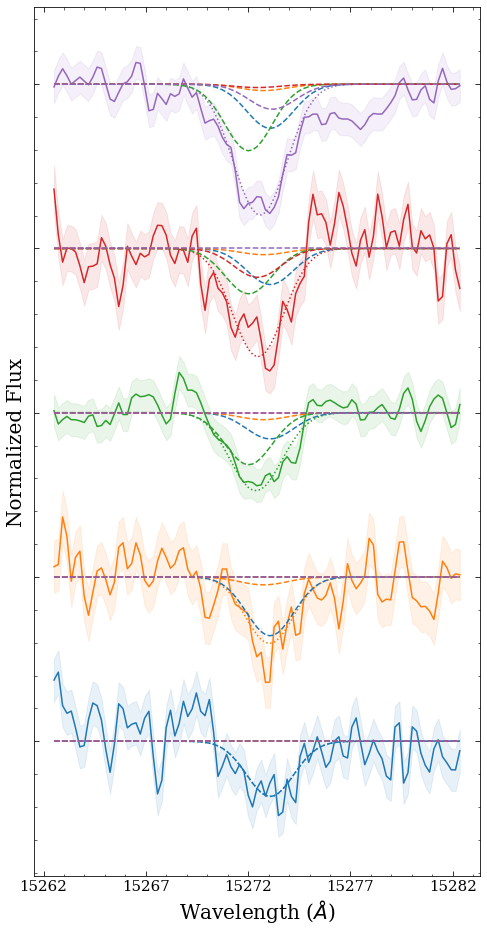

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 7
(5, 95) (5, 4, 95) (5, 4)


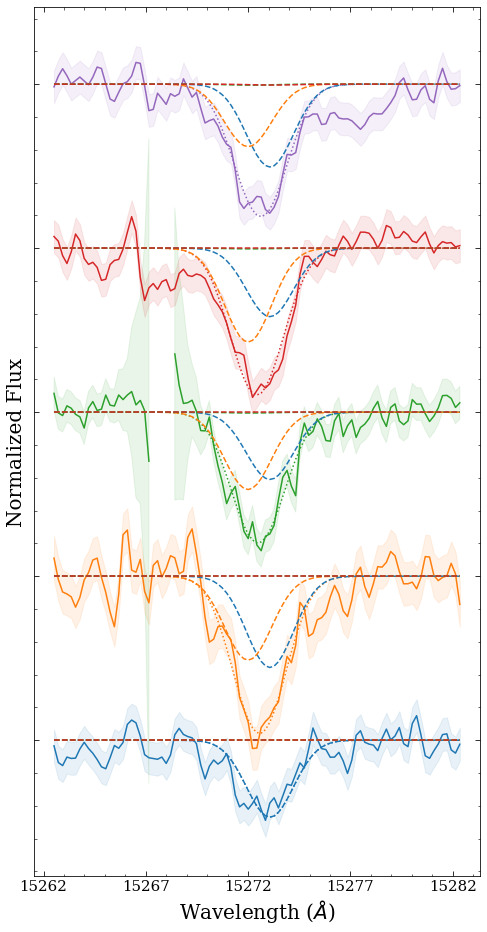

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 8
(5, 95) (5, 4, 95) (5, 4)


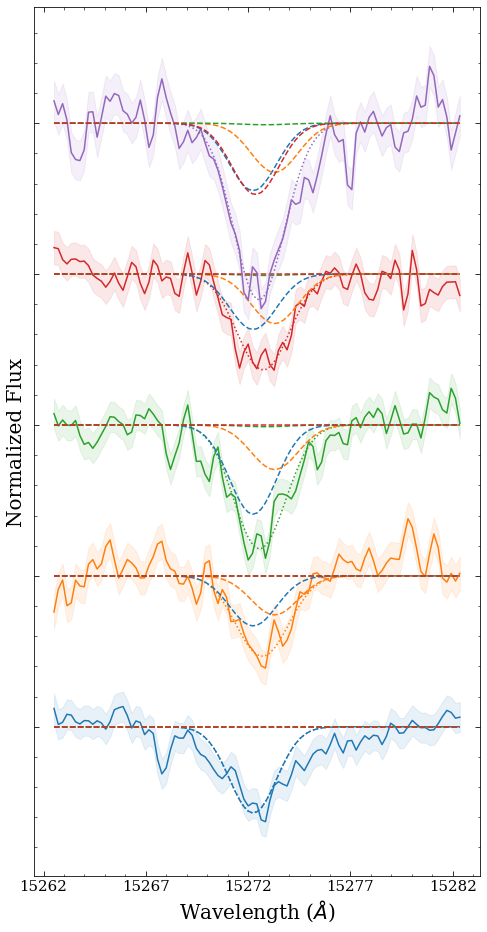

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 9
(5, 95) (5, 5, 95) (5, 5)


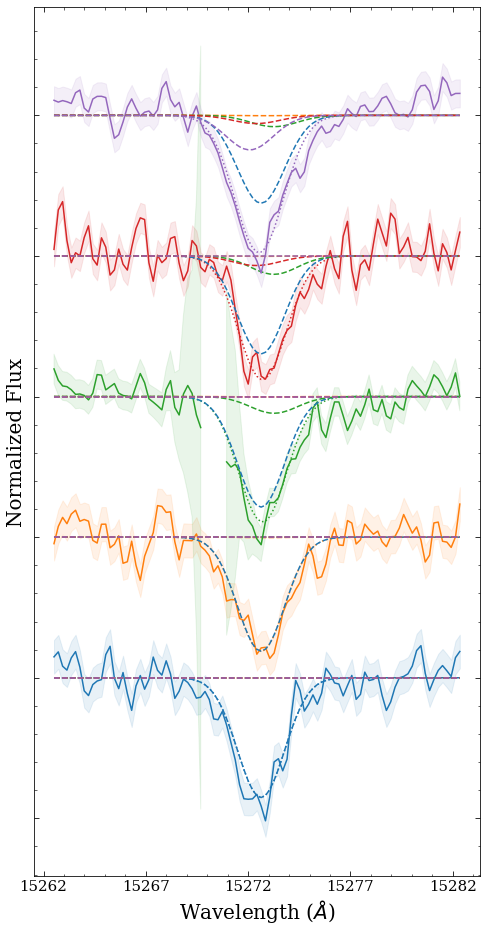

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 10
(5, 95) (5, 5, 95) (5, 5)


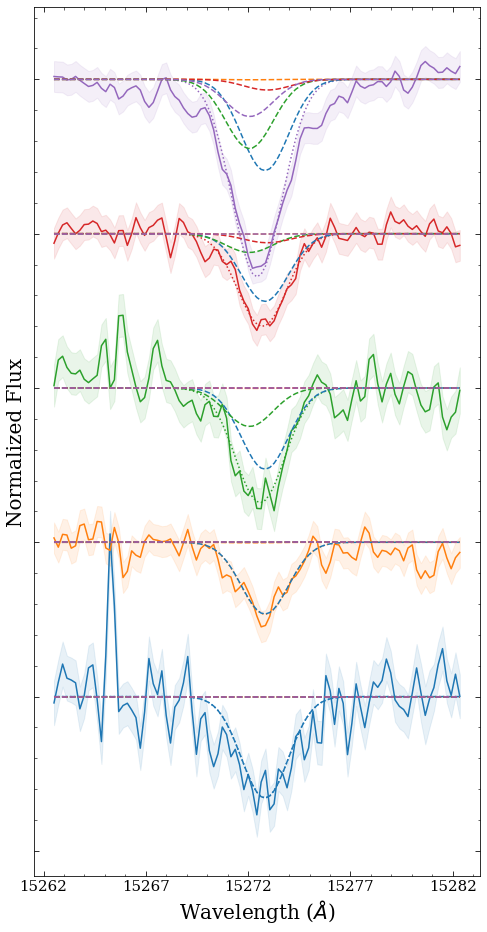

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 11
(5, 95) (5, 5, 95) (5, 5)


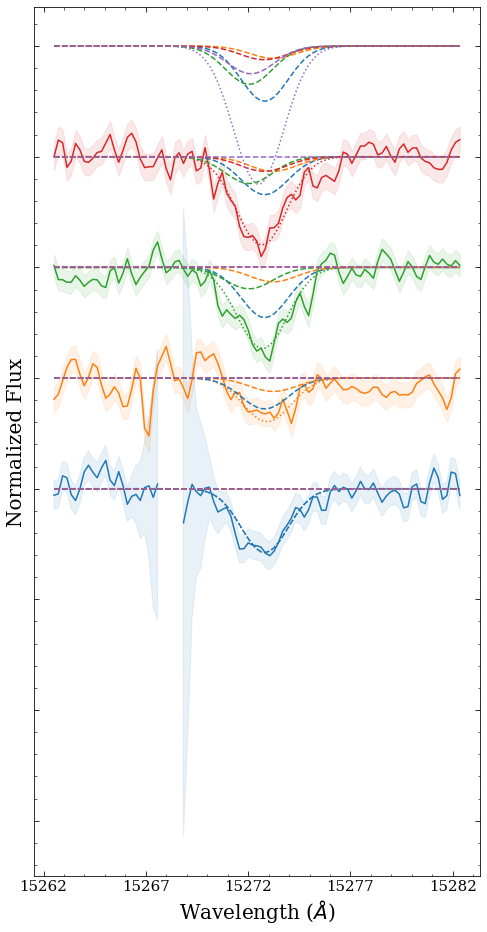

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 12
(5, 95) (5, 5, 95) (5, 5)


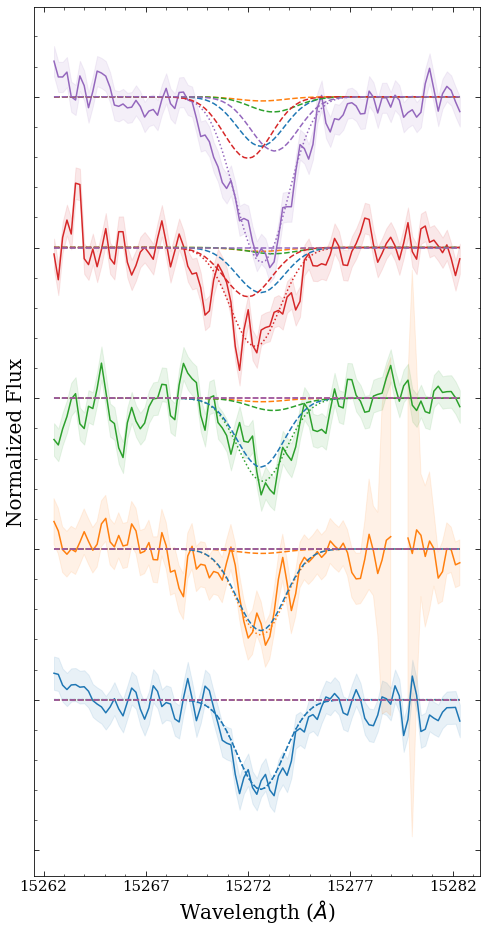

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 13
(5, 95) (5, 5, 95) (5, 5)


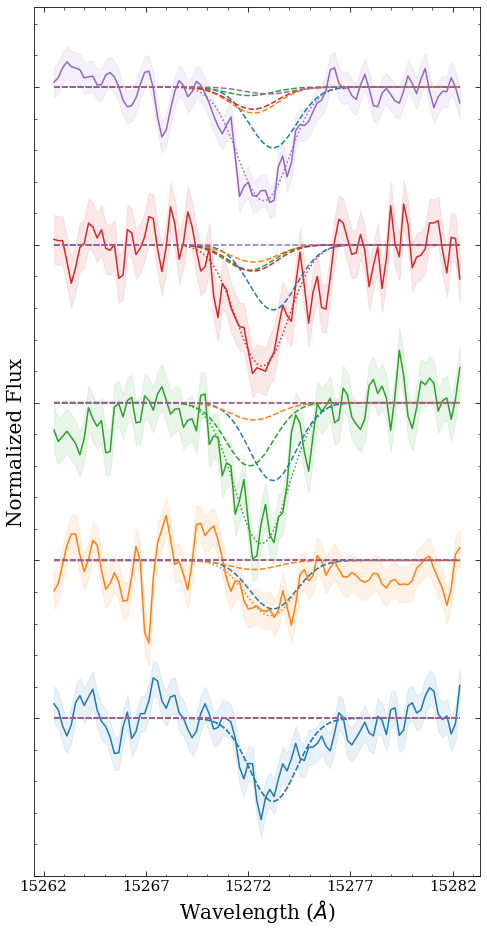

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 14
(5, 95) (5, 5, 95) (5, 5)


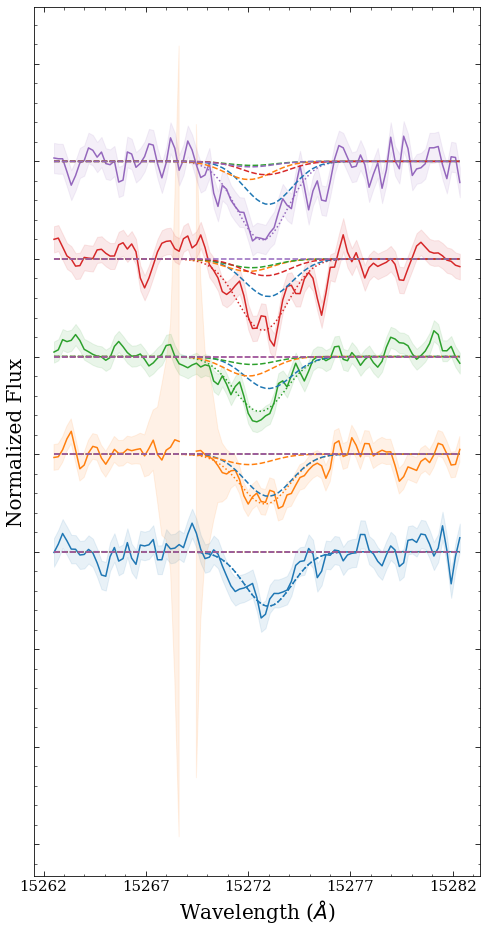

N 15
(6, 95) (6, 6, 95) (6, 6)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


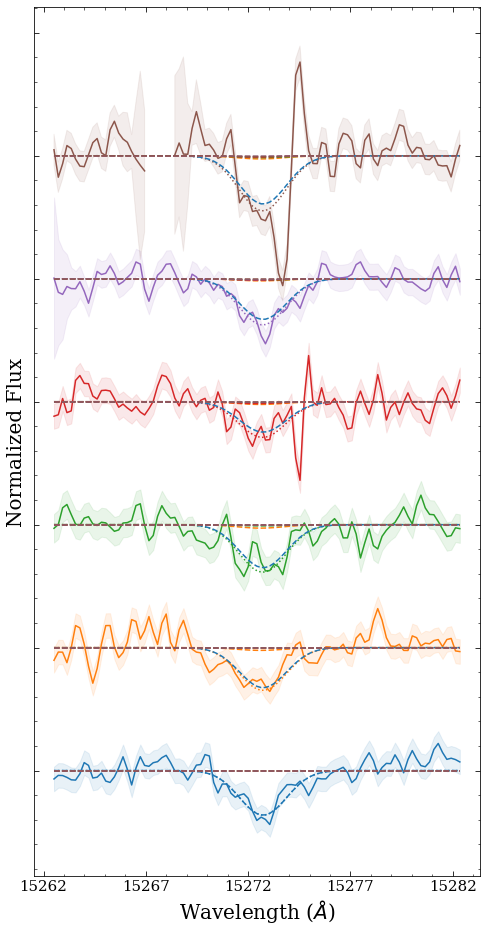

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 16
(5, 95) (5, 5, 95) (5, 5)


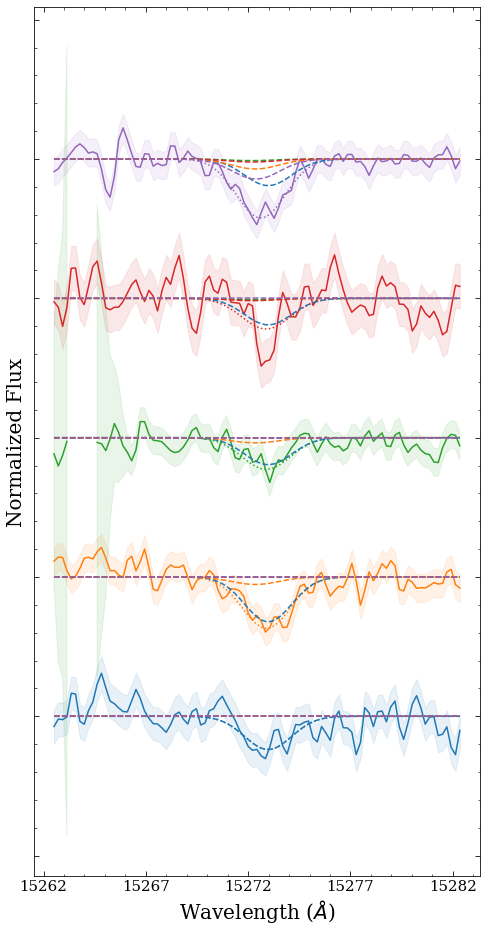

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


N 17
(5, 95) (5, 5, 95) (5, 5)


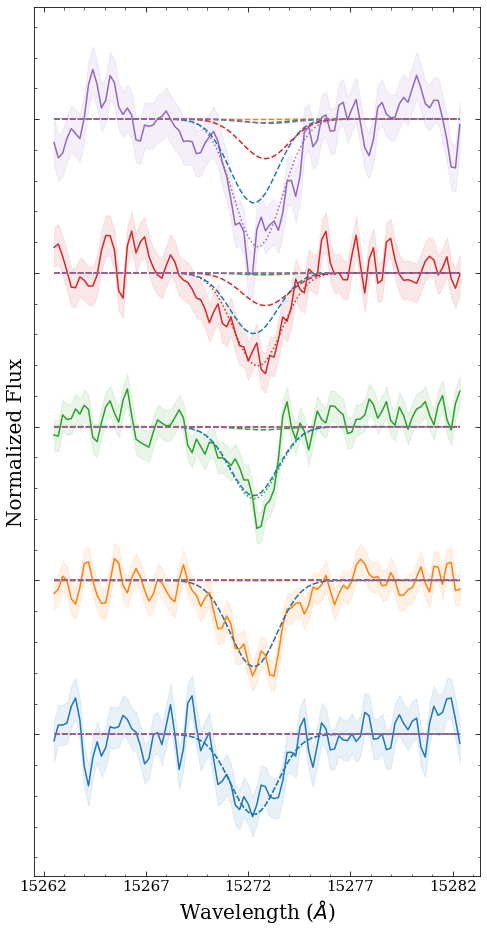

In [29]:
def model_signals_thing(rvelo, sl, dAVdd):
    # dAVdd = sl.dAVdd
    signals = np.zeros((len(sl.stars), len(wavs_window)))
    unsummed_signals = np.zeros((len(sl.stars), len(sl.bins)-1,len(wavs_window)))
    print(signals.shape, unsummed_signals.shape, sl.dAVdd.shape)
    peak_wavelength = dopplershift(rvelo)
    wavs_grid = np.tile(wavs_window, (len(sl.bins) - 1, 1))
    voxel_DIB_unscaled = np.exp(-(wavs_grid - peak_wavelength[:, np.newaxis])**2 / (2 * sigma0**2))
    amp = differentialAmplitude(dAVdd, sl.bins[1:]-sl.bins[:-1])

    def single_signal(amp, bindex):
        amp[bindex:] = 0 # THIS MIGHT NEED TO BE -1
        # print(amp)

        voxel_DIB_scaled = -voxel_DIB_unscaled *  amp[:, np.newaxis] 
        summed_DIB = np.sum(voxel_DIB_scaled, axis = 0)
        # continuum = lambda x, m, b : m * (x - lambda0) + b
        # cont = continuum(wavs_window, 0, b)
        return summed_DIB  + 1, voxel_DIB_scaled 


    for i in range(len(sl.stars)):
        star = sl.stars[i]
        dAVdd_star = dAVdd[i, :]
        # amp = Differential_Amplitude(dAVdd_star, self.bins[1:]-self.bins[:-1])
        amp = differentialAmplitude(dAVdd_star, 1)

        bin_index = sl.bin_inds[i]
        # signals[i, :] = single_signal(bin_index)
        signals[i, :], unsummed_signals[i, :, :] = single_signal(amp, bin_index)

    return signals, unsummed_signals

def plot_DIBS_thing(sampler, sl, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        bindex = sl.bin_index[ii]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(bindex), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(lambda0-10, lambda0 + 10, 4))

    ax.set_yticklabels('')

def plot_DIBS_freeze(sampler, plot_objs = None):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, 50:, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[50:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)
    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    ax.set_xticks(np.linspace(lambda0-10, lambda0 + 10, 8))
    ax.set_yticklabels('')

def plot_DIBS_logprob(sampler, sl, plot_objs = None, bestprob = True):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8, 16))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)
    nstars = len(sl.stars)

    samples = sampler.chain[:, :, :].reshape((-1, sampler.chain.shape[-1]))

    medians = np.nanmedian(samples[-100:, :], axis = 0)

    # med_dAV_dd = np.nanmedian(samples[50:, :], axis = 0)

    # print(medians)

    ## NEW THING
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    med_velo = medians[:ndim]

    med_dAV_dd = medians[ndim:].reshape(-1, ndim)
    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)

    order_inds = np.array(np.argsort(sl.stars['DIST']))
    # print(order_inds)

    signal_recreated, signal_recreated_unsummed = model_signals_thing(med_velo, sl, med_dAV_dd) 
    # print('sru shape ', signal_recreated_unsummed.shape)
    # for i in range(len(sl.voxel_dAVdd)):
    for i in range(len(order_inds)):
        ii = order_inds[i]
        # signal_recreated_here = sl.model_signals(med_velo[i], dAVdd = med_dAV_dd[i, :])
        ax.plot(wavs_window, sl.signals[ii, :] + 0.05 * i, color = 'C{}'.format(i))
        ax.fill_between(wavs_window, sl.signals[ii, :] + sl.signal_errs[ii, :] + 0.05 * i,
                         sl.signals[ii, :] - sl.signal_errs[ii, :] + 0.05 * i, color = 'C{}'.format(i), alpha = 0.1)

        ax.plot(wavs_window, signal_recreated[ii, :] + 0.05 * i , color = 'C{}'.format(i), linestyle = 'dotted',)# label = 'recreated signal')

        for j in range(len(sl.bins)-1):
            ax.plot(wavs_window, signal_recreated_unsummed[ii, j, : ] + 1 + 0.05 * i, color='C{}'.format(j), linestyle = 'dashed', alpha = 1)

    ax.legend(loc = 'lower left', fontsize = 20)

    ax.set_xlabel('Wavelength ($\AA$)', fontsize = 20)
    ax.set_ylabel('Normalized Flux', fontsize = 20)
    fig.set_facecolor('white')

    # ax.set_xticks(np.arange(lambda0-10, lambda0 + 12, 4))
    ax.set_xticks(np.linspace(15272-10, 15272 + 10, 5))

    ax.set_yticklabels('')

for i in range(len(sightlines)):
    print('N', i)
    fig, ax = plt.subplots(figsize = (8, 16))

    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    plot_DIBS_logprob(sampler_i, sl_i, plot_objs = (fig, ax))
    ymin, ymax = ax.get_ylim()
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )

    lp_i = sampler_i.lnprobability
    lp_med_i = np.nanmedian(lp_i[:, -100:])
    # ax.text(lambda0, ymax - .01, 'sl index {}'.format(i) )
    # ax.text(lambda0, ymax - .015, 'lnprob {}'.format(lp_med_i) )

    name_i = 'dibs_' + str(i)
    # fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/231015_DIBmodels/{}.png'.format(name_i), overwrite = True)

    plt.show()




In [38]:
sl_davdd = np.zeros((len(l_sample.flatten()), dust_data.dustmap.shape[-1]))
for i in range(len(l_sample.flatten())): 
    l_i, b_i = l_sample.flatten()[i], b_sample.flatten()[i]
    l_ind, b_ind = find_nearest(l_i, b_i)
    sl_davdd[i, :] = np.copy(dust_data.dustmap[b_ind, l_ind, :])

In [39]:
def plot_velo(sampler, sl , min_walker = None, plot_objs = None, color = None, plot_lines = False, plot_box = False, plot_violin = False, bestprob = False,):
    if plot_objs == None:
        fig, ax = plt.subplots(figsize = (8,6))
    else:
        fig, ax = plot_objs
    # ax.plot(wavs_window, dstack1, label = '300-480 pc')
    # ax.plot(wavs_window, dstack2, label = '480-800 pc')
    ndim = len(sl.voxel_dAVdd)

    walker_max = sampler.chain.shape[1]

    if min_walker is None:
        min_walker_val = -100
    # else:
    min_walker_val = walker_max - min_walker

    samples = sampler.chain[:, min_walker_val:, :].reshape((-1, sampler.chain.shape[-1]))

    vel_samples = sampler.chain[:, min_walker_val, :].reshape((-1, sl.ndim))
    avg_av = np.nansum(np.median(sl.dAVdd, axis = 0))

    


    medians = np.nanmedian(samples[min_walker_val:, :], axis = 0)
    if bestprob:
        lp = sl_i.sampler.lnprobability
        lp[:, :-100] = -np.infty
        w_ind, stp_ind = np.unravel_index(np.argmax(lp), lp.shape)

        medians = sl_i.sampler.chain[w_ind, stp_ind, :]

    stdevs = np.nanstd(samples[min_walker_val:, :], ddof = 1, axis = 0)

    med_velo = medians[:ndim]
    std_velo = stdevs[:ndim]


    med_dAV_dd = medians[ndim:]
    med_dAV_dd = stdevs[ndim:]

    perc16, perc50,  perc84 = (np.percentile(samples[min_walker_val:, :], 16, axis = 0), 
                               np.percentile(samples[min_walker_val:, :], 50, axis = 0),
                               np.percentile(samples[min_walker_val:, :], 84, axis = 0) )
    velo16, velo50, velo84 = (perc16[:ndim], perc50[:ndim], perc84[:ndim])

    # med_dAV_dd = np.tile(med_dAV_dd, len(sl.stars)).reshape(len(sl.stars), -1)


    # ax.scatter((a.bins[1:] + a.bins[:-1] ) /2 , med_velo)
    # if
    # for i in range(len(sl.bins)-1): 
    #     ax.hlines(med_velo[i], sl.bins[i], sl.bins[i+1], linestyle = 'dashed')
    #     if i < len(sl.bins) -2:
    #         ax.vlines(sl.bins[i+1], med_velo[i], med_velo[i+1], linestyle = 'dashed')

    if color == None:
        color_choice = 'k'
    else:
        color_choice = color
    

    if plot_box:
        # ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'dashed', linewidth = 0.5)
        # ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = color_choice)
        ax.hlines(velo50, sl.bins[:-1], sl.bins[1:], color = 'k')


        for j in range(len(sl.bins)-1):
            # ax.fill_between([sl.bins[i], sl.bins[i +1]], med_velo[i]+std_velo[i], med_velo[i]-std_velo[i], 
            #                 alpha = 0.3, color = color_choice, hatch = '/')
            ax.fill_between([sl.bins[j], sl.bins[j +1]], velo84[j], velo16[j], 
                    alpha = 0.3, color = 'C{}'.format(j))

        if plot_violin:
            pos = (sl.bins[1:] + sl.bins[:-1])/2
            w = (sl.bins[1:] - sl.bins[:-1])
            ax.violinplot(vel_samples, pos, widths = w, showmeans=True, showextrema=False, showmedians=True)



    else:  
        # ax.errorbar((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
        # ax.scatter((sl.bins[1:] + sl.bins[:-1] ) /2 , med_velo, c = color_choice)
        ax.errorbar((sl.bins[1:] ) , med_velo, yerr = std_velo, fmt = '.', color = color_choice, capsize = 5)
        ax.scatter((sl.bins[1:] ) , med_velo, c = color_choice)
        if plot_lines:
            ax.hlines(med_velo, sl.bins[:-1], sl.bins[1:], color = color_choice, linestyle = 'solid', linewidth = .5)



    # ax.errorbar((sl.bins[1:]),med_velo, xerr = (sl.bins[1:] - sl.bins[:-1], np.zeros(med_velo.shape)), yerr = std_velo, fmt = '.' )
    ax.set_xlim(350, 600)
    ax.set_xlabel('Distance (pc)')
    ax.set_ylabel('Radial Velocity (km/s)')

    dist_xx = (sl.bins[1:] + sl.bins[:-1] ) /2
    # med_velo

    return fig, ax, dist_xx, med_velo, std_velo


N  0
[ 78.93037415 288.17993164 426.85144043 480.41622925 554.69116211]
[-4.80066855  9.13421688 -6.66007738 -2.59579088  9.40454464]
[426.85144043 480.41622925 554.69116211]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


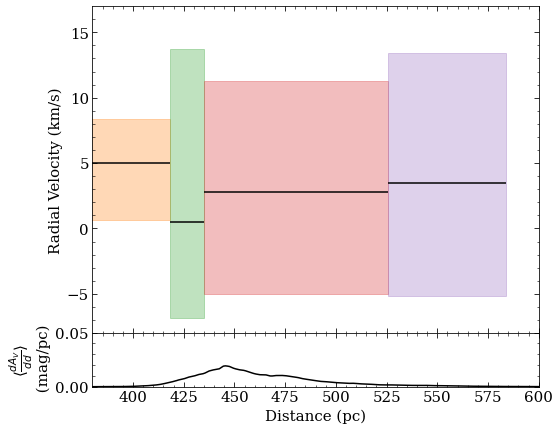

N  1
[225.25550842 457.98275757 470.74609375 481.76266479 506.38983154]
[12.24536379 -7.97903534 -5.47597595 15.16340565 10.58352877]
[457.98275757 470.74609375 481.76266479 506.38983154]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


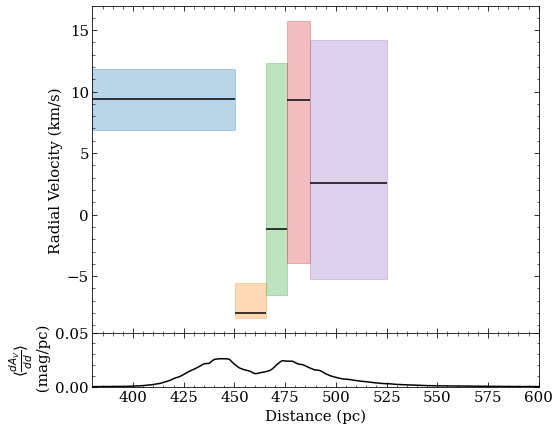

N  2
[209.13446045 433.10821533 461.99261475 481.04272461 530.97290039]
[ 6.25285428  2.52888267 -4.24880664  8.80212404 11.91505413]
[433.10821533 461.99261475 481.04272461 530.97290039]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


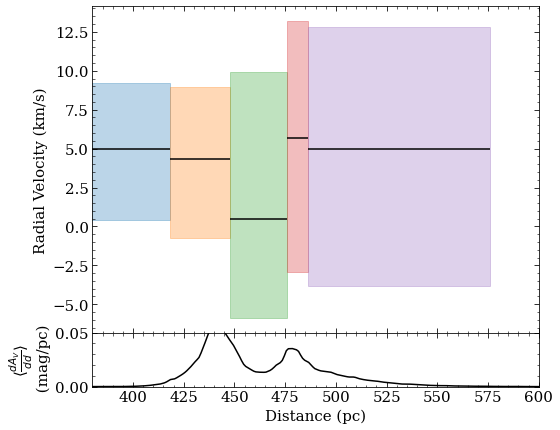

N  3
[197.89797974 438.05532837 485.31970215 525.91424561 568.609375  ]
[10.7201914  -4.28706574 14.60818783 -7.87230521 16.5603171 ]
[438.05532837 485.31970215 525.91424561 568.609375  ]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


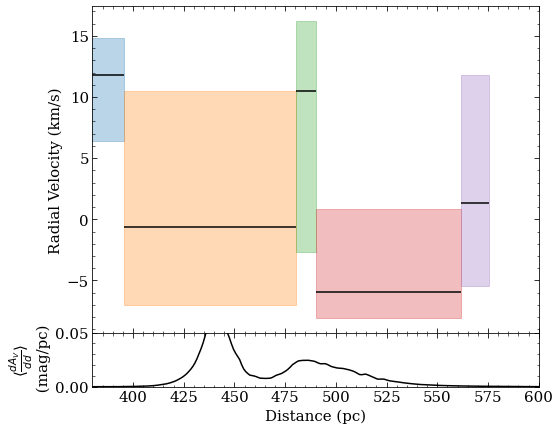

N  4
[203.15335083 421.97085571 442.64001465 476.16687012 545.49346924]
[ 5.66451279 -7.67178037 -6.91018566 13.12599406 -3.65741896]
[421.97085571 442.64001465 476.16687012 545.49346924]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


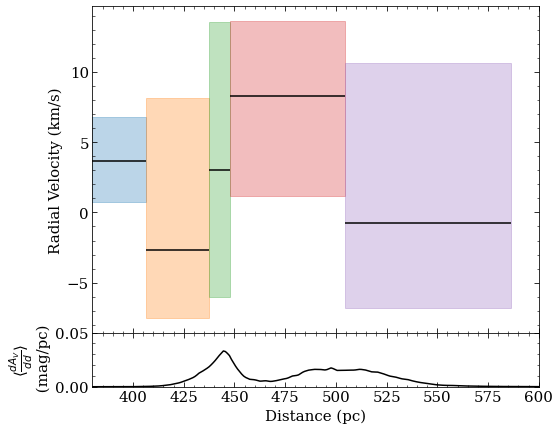

N  5
[189.54560852 384.10205078 440.43005371 515.91638184 554.87792969]
[-1.28750456 -2.37434763 17.40049753 16.86136683 -2.83536932]
[384.10205078 440.43005371 515.91638184 554.87792969]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


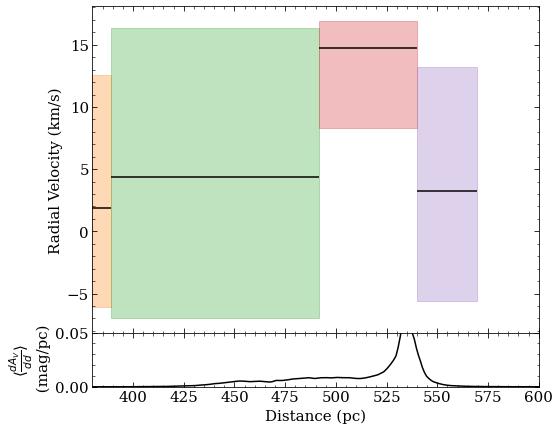

N  6
[206.06762695 417.14025879 443.22155762 479.97323608 602.42541504]
[12.89316729  6.58492918 -7.76135044  0.61818756 15.03167431]
[417.14025879 443.22155762 479.97323608]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


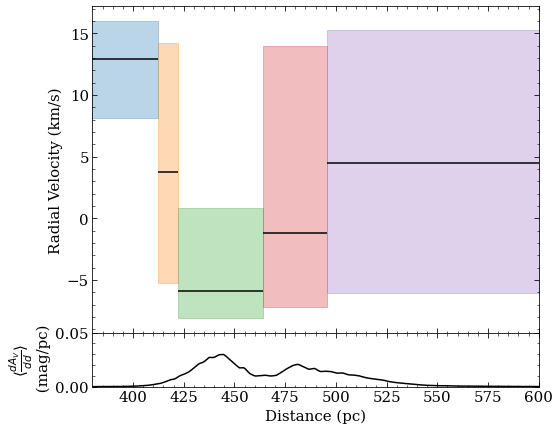

N  7
[211.53045654 489.09066772 560.12542725 637.1663208 ]
[12.68440646 -8.30351171 -5.77181739 15.85337966]
[489.09066772 560.12542725]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


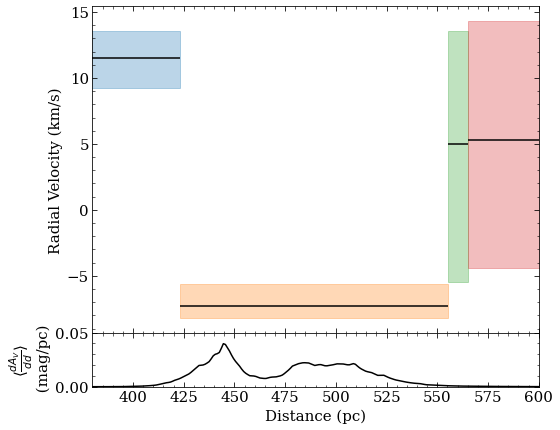

N  8
[125.85613251 329.00949097 411.31170654 509.96740723]
[-3.50606288 17.13830716  8.05489749 -1.15517776]
[411.31170654 509.96740723]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


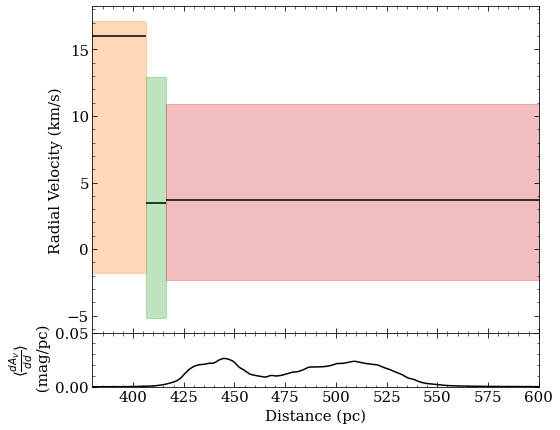

N  9
[187.08995056 391.30517578 420.15991211 442.50958252 476.16537476]
[ 4.15273543  7.55718112 16.53812491 -0.43258373 -6.66400386]
[391.30517578 420.15991211 442.50958252 476.16537476]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


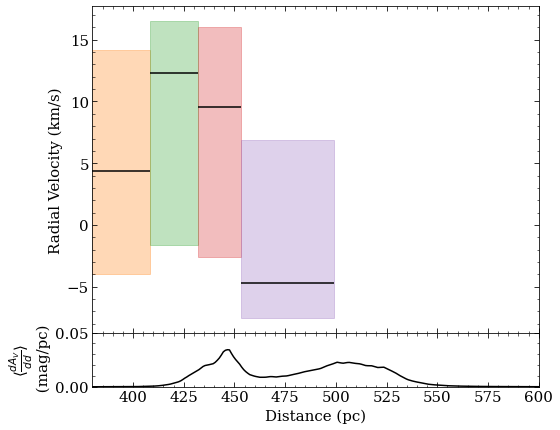

N  10
[199.62854004 404.26208496 431.84075928 459.41946411 472.32495117]
[ 7.88209409 -4.95662594 -6.992105   10.10784459 -6.83552547]
[404.26208496 431.84075928 459.41946411 472.32495117]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


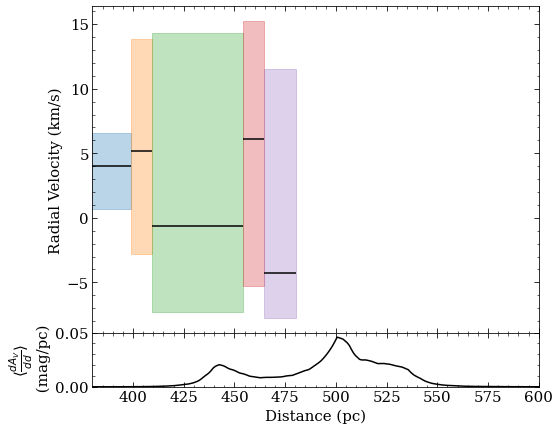

N  11
[226.2718811  466.19689941 495.03939819 515.23370361 721.83813477]
[ 7.66324975 15.86397087 -7.32384168  7.03087822 -5.47502497]
[466.19689941 495.03939819 515.23370361]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


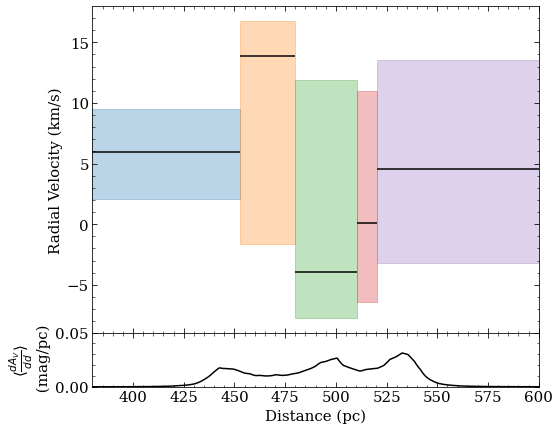

N  12
[207.3690033  419.74301147 429.75302124 445.83532715 484.90942383]
[ 3.84677355  4.89664457 15.74195761 -8.48417667 17.066064  ]
[419.74301147 429.75302124 445.83532715 484.90942383]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


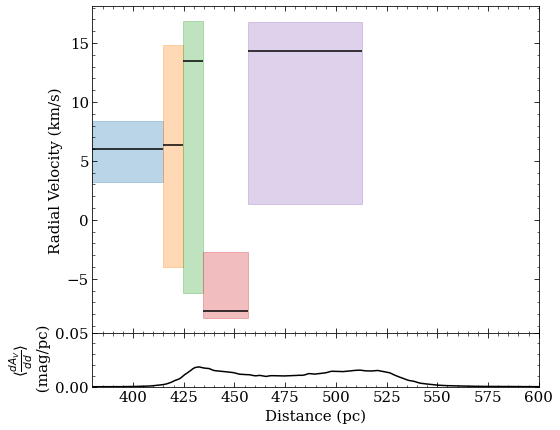

N  13
[202.04191589 441.96694946 509.50079346 566.07592773 598.00531006]
[15.61005    -2.82781449 -6.88067583 -3.54540673 10.95900812]
[441.96694946 509.50079346 566.07592773 598.00531006]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


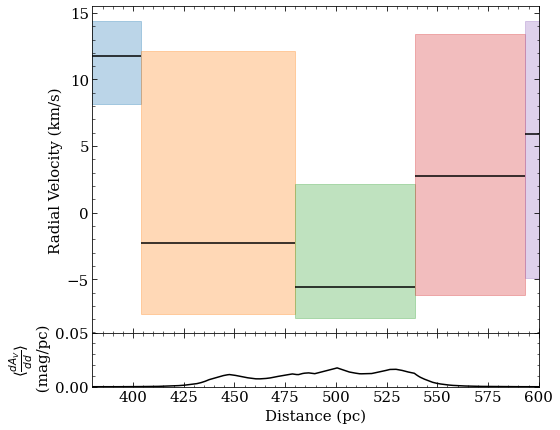

N  14
[211.19619751 450.85778809 484.32821655 500.39001465 552.22357178]
[11.18477556 -7.70588142 -4.5731267   8.71904837 -5.64560395]
[450.85778809 484.32821655 500.39001465 552.22357178]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


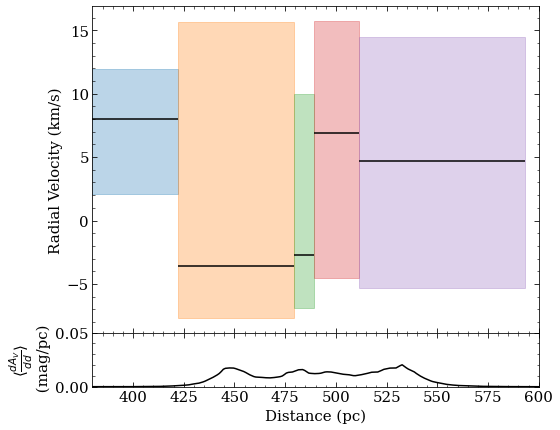

N  15
[232.42060852 483.31585693 511.32839966 529.37231445 542.88555908
 552.89770508]
[ 6.08171235  3.76146969  4.82583369  0.42670365 -4.26165079  2.89316264]
[483.31585693 511.32839966 529.37231445 542.88555908 552.89770508]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


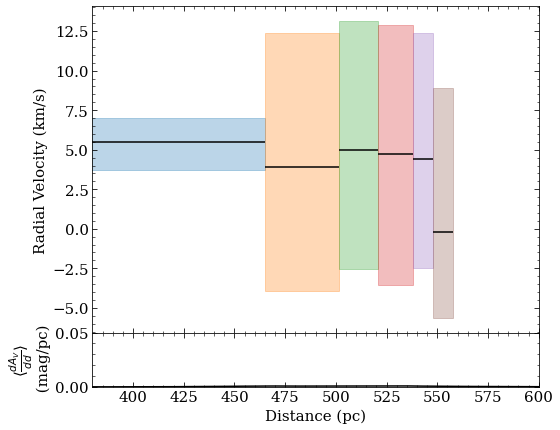

N  16
[201.60366821 423.92895508 449.6555481  461.94467163 530.94549561]
[10.97675649 -1.2452944  -5.36644039 -4.11916325 -0.5919013 ]
[423.92895508 449.6555481  461.94467163 530.94549561]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


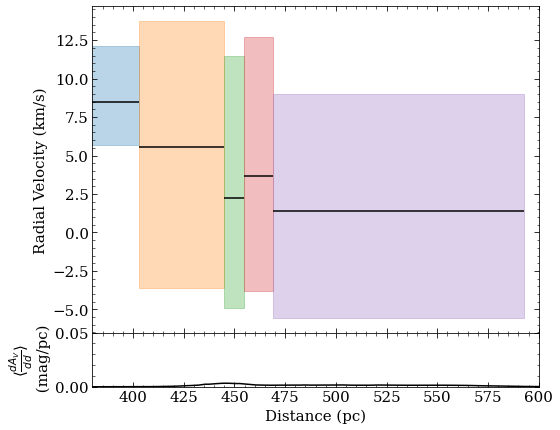

N  17
[202.86845398 410.74191284 428.74060059 483.35723877 551.98327637]
[-2.82753548 -3.92391822  5.97791833  8.31158542 13.66226803]
[410.74191284 428.74060059 483.35723877 551.98327637]
didn't fit properly
name 'curve_fit' is not defined


/tmp/ipykernel_2366601/2648327418.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "overwrite" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )


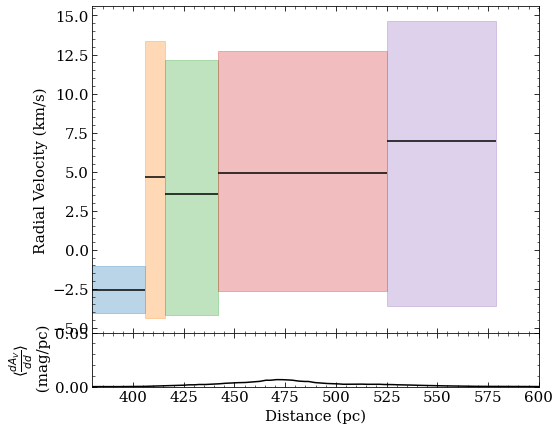

In [40]:
avs = np.zeros(len(sightlines))
for i in range(len(sightlines)):
    sl_i = sightlines[i]
    avs[i] = np.sum(sl_i.voxel_dAVdd)

cnorm = matplotlib.colors.Normalize(np.min(avs), np.max(avs))
cmap = plt.get_cmap('viridis')
mappable = matplotlib.cm.ScalarMappable(norm = cnorm,  cmap = cmap)


sightlines_slopes = np.zeros(len(sightlines))
sightlines_slopes_err = np.zeros(len(sightlines))


dist_xx_sl = np.array([])
velo_yy_sl = np.array([])
std_velo_sl = np.array([])


for i in range(len(sightlines)): 
    print('N ', i)
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (8,7), sharex = True, gridspec_kw={'height_ratios': [6,1], 'hspace': 0})


    dist_xx = np.array([])
    velo_yy = np.array([])
    std_velo = np.array([])
    sl_i = sightlines[i]
    sampler_i = sl_i.sampler
    color = cmap(cnorm(avs[i]))
    color = 'C'+str(i)
    _, __, dist_xx_i, velo_yy_i, std_velo_i = plot_velo(sampler_i, sl = sl_i, min_walker = 10, plot_objs = (fig, axs[0]), color = color, plot_box = True, plot_violin=False, bestprob = True)
    dist_xx = np.concatenate([dist_xx, dist_xx_i])
    velo_yy = np.concatenate([velo_yy, velo_yy_i])
    std_velo = np.concatenate([std_velo, std_velo_i])

    print(dist_xx)
    print(velo_yy)

    dist_sort = np.argsort(dist_xx)
    # print(dist_sort)

    try:
        filt = (dist_xx[dist_sort] >= 380) & (dist_xx[dist_sort] <= 600)
        print(dist_xx[dist_sort][filt])
        fit_result = curve_fit(line, dist_xx[dist_sort][filt], velo_yy[dist_sort][filt], sigma = std_velo[dist_sort][filt])
        print(fit_result)
        fit_params = fit_result[0]
        fit_result_err = np.sqrt(np.diag(fit_result[1]))
        xx_plot = np.linspace(380, 600)

        # axs[0].plot(xx_plot, line(xx_plot, fit_params[0], fit_params[1]), label = 'SL ' + str(i))
        sightlines_slopes[i] = fit_params[0] 
        sightlines_slopes_err[i] = fit_result_err[0]
    except Exception as e:
        print('didn\'t fit properly')
        print(e)
        sightlines_slopes[i] = np.nan

    # ax.plot(sl.stars['DIST'], )
    # axs[0].fill_between(xx_plot, line(xx_plot, fit_params[0] + fit_result_err[0], fit_params[1] + fit_result_err[1]),
    #                     line(xx_plot, fit_params[0] - fit_result_err[0], fit_params[1] - fit_result_err[1]), alpha = 0.1, color = 'C0')

    # ymin, ymax = ax.get_ylim()
    axs[1].plot(dust_data.distance, sl_davdd[i, :], color = 'k')
    # ax.set_ylim(ymin, ymax)
    axs[1].set_xlim(380, 600)
    axs[1].set_xlabel('Distance (pc)')
    axs[1].set_ylabel(r'$ \langle \frac{dA_V}{dd} \rangle $' + '\n (mag/pc)')
    axs[1].set_ylim(0, 0.05)
    fig.set_facecolor('white')

    # for j in range(len(sl_i.stars)):
    #     axs[1].scatter(sl_i.stars['DIST'][j], sl_davdd[i, find_nearest_dist(sl_i.stars['DIST'][j])])

    # axs[0].legend()
    name_i = 'veldist_' + str(i)
    fig.savefig('/uufs/astro.utah.edu/common/home/u1371365/figures/230921_qualfigs/2301015_veldist/{}.png'.format(name_i), overwrite = True )

    plt.show()

    dist_xx_sl = np.concatenate([dist_xx_sl, dist_xx])
    velo_yy_sl = np.concatenate([velo_yy_sl, velo_yy])
    std_velo_sl = np.concatenate([std_velo_sl, std_velo])